In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from model_funcs import *

In [6]:
LSM_datafile = "LSM_LOG_20220402-132105"
SIFT1_datafile = "SIFT1_LOG_20220402_124920"
SIFT2_datafile = "SIFT2_LOG_20220402_124347"

datafile = '../Data/Fullscale2/' + SIFT2_datafile + '.csv'

In [14]:
#def calc_displacement(datafile, zero_out=False):
zero_out = 0
sim_drogue
sim_main
sim_landing

# Read in the dataframe
fields = ['Timestamp', 'Pres',
'Roll', 'Pitch', 'Yaw',
'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z']

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

# Parameters
dt = 0.001
B = 6.5*10**-3   # temperature lapse rate in troposphere in K/m
R = 287   # ideal gas constant in J/(kg.K)
g = 9.80665  # gravity at sea level in m/s2
T0 = 288.15   # standard air temperature in K
P0 = 101.325   # standard air pressure in kPa
pi = 3.1415
ft = 3.2884  # ft/m

# Read Data Fields
imu_t = df['Timestamp'].values
imu_t = imu_t - imu_t[0]
imu_N = len(imu_t)
imu_ax = df['LinearAccelNed X'].values
imu_ay = df['LinearAccelNed Y'].values
imu_az = df['LinearAccelNed Z'].values * -1
imu_pres = df['Pres']

################## INIT VECTORS  ##################
imu_vx, imu_vy, imu_vz, imu_x, imu_y, imu_z = (np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)))

################## Find velocity and position  ##################
for i in range(imu_N-1):
    imu_vz[i+1] = imu_vz[i] + imu_az[i]*(imu_t[i+1] - imu_t[i])
    imu_z[i+1] = imu_z[i] + imu_vz[i]*(imu_t[i+1] - imu_t[i])

    imu_vx[i+1] = imu_vx[i] + imu_ax[i]*(imu_t[i+1] - imu_t[i])
    imu_x[i+1] = imu_x[i] + imu_vx[i]*(imu_t[i+1] - imu_t[i])

    imu_vy[i+1] = imu_vy[i] + imu_ay[i]*(imu_t[i+1] - imu_t[i])
    imu_y[i+1] = imu_y[i] + imu_vy[i]*(imu_t[i+1] - imu_t[i])

################## Find alt  ##################
vec_NASA_pres = np.vectorize(nasa_pres)
imu_alt = vec_NASA_pres(imu_pres, P0, T0, R, B, g)   # * ft + 600
imu_alt = imu_alt - imu_alt[imu_N-1]
imu_alt = [val if val > 0 else 0 for val in imu_alt]

# Find drogue peak and calc wind velocity
imu_start_time, imu_end_time, takeoff_time, a_1 = find_peak_and_wait(np.array(imu_ax), imu_t, takeoff_delay=1.5, signal_length=2)
imu_start_time = 440
imu_end_time = 555

trunc_signal = imu_ax[imu_start_time:imu_end_time]
trunc_time = imu_t[imu_start_time:imu_end_time]

if zero_out and len(trunc_signal[trunc_signal > 0])>0 and len(trunc_signal[trunc_signal < 0])>0:
    smoothed_signal = [0]
else:
    smoothed_signal = calc_moving_avg(imu_ax, 25, imu_t, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80)
    smoothed_signal = smoothed_signal[imu_start_time:imu_end_time]

if max(np.array(smoothed_signal)) > 0.1:
    max_accel = max(np.array(smoothed_signal))
    flip = 1
else:
    max_accel = max(abs(np.array(smoothed_signal)))
    flip = -1
w_0 = 0.5*max_accel*(trunc_time[-1] - trunc_time[0])
K = a_1/w_0**2 

## DERIVED PARAMETERS
w_0_mph = w_0/0.44704
z_0 = max(imu_alt) # apogee altitude in m

################## CONSTANT WIND PROFILE & AIR DENSITY  ##################
wind_profile_x = np.zeros((imu_N))
density_profile = np.zeros((imu_N))

z0 = max(imu_alt) # apogee altitude in m

for i in range(imu_N):
    T = T0 - B * imu_alt[i]
    P = P0 * 1000 * (T/T0)**(g/(R*B))
    density_profile[i] = P/(R*T)
    if imu_alt[i] < 2:
        wind_profile_x[i] = w_0*((2/z0)**(1/7))
    else:
        wind_profile_x[i] = w_0*((imu_alt[i]/z0)**(1/7))

x1, t1 = model1(imu_t[imu_start_time], imu_t, imu_ax, imu_vx, imu_x, dt, a_1, imu_alt, wind_profile_x, density_profile, K)
x2, t2 = model2(imu_t, dt, imu_alt, wind_profile_x, density_profile, K)

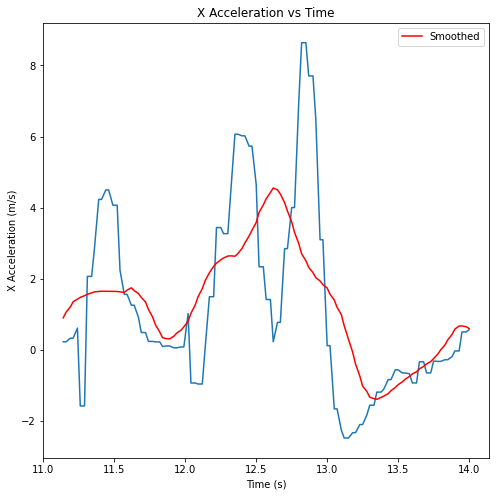

In [15]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(trunc_time, imu_ax[imu_start_time:imu_end_time])
ax.plot(trunc_time, smoothed_signal, color='red', label='Smoothed')
#ax.plot(t2, x2*flip, color='green', label='Model 2 (after takeoff)')
ax.set_title("X Acceleration vs Time")  # 'interpreter','latex', 'FontSize', 16
ax.set_xlabel("Time (s)")  # 'interpreter','latex', 'FontSize', 16
ax.set_ylabel("X Acceleration (m/s)")  # 'interpreter','latex', 'FontSize', 16
ax.legend()
plt.show()

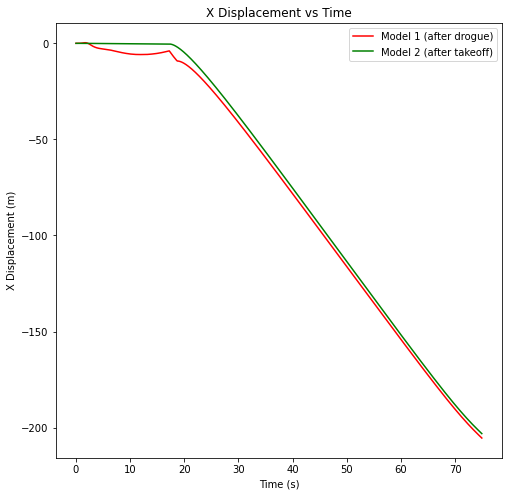

In [69]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(t1, x1*flip, color='red', label='Model 1 (after drogue)')
ax.plot(t2, x2*flip, color='green', label='Model 2 (after takeoff)')
ax.set_title("X Displacement vs Time")  # 'interpreter','latex', 'FontSize', 16
ax.set_xlabel("Time (s)")  # 'interpreter','latex', 'FontSize', 16
ax.set_ylabel("X Displacement (m)")  # 'interpreter','latex', 'FontSize', 16
ax.legend()
plt.show()

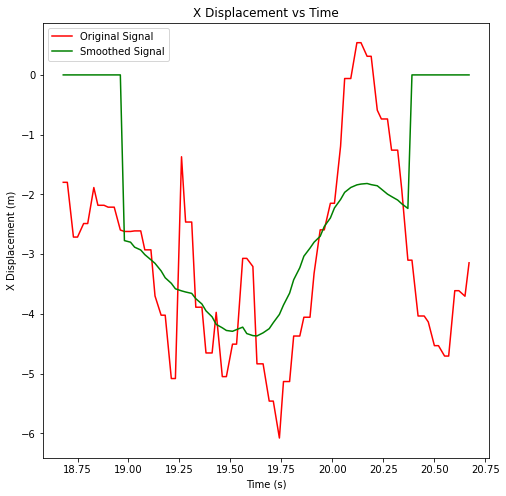

In [70]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(trunc_time, trunc_signal, color='red', label='Original Signal')
ax.plot(trunc_time, smoothed_signal, color='green', label='Smoothed Signal')
ax.set_title("X Displacement vs Time")  # 'interpreter','latex', 'FontSize', 16
ax.set_xlabel("Time (s)")  # 'interpreter','latex', 'FontSize', 16
ax.set_ylabel("X Displacement (m)")  # 'interpreter','latex', 'FontSize', 16
ax.legend()
plt.show()

In [47]:
datafile = '../Data/Trunc_Fullscale1.csv'

C:\Users\kdmen\miniconda3\envs\NSCenv\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars


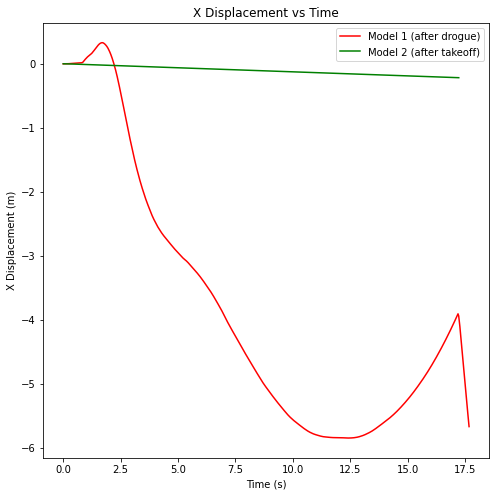

In [54]:
ts_1, ss_1, ttime_1 = calc_displacement(datafile, zero_out=True)

In [56]:
ts_1

array([-1.01929 , -0.811815, -0.811815, -0.883791, -0.423885, -0.423885,
       -0.54654 , -0.54654 , -0.487176, -0.513239, -0.513239, -0.573149,
       -0.573149, -0.579501, -0.579501, -0.702994, -0.686675, -0.686675,
       -0.873731, -0.873731, -0.867122, -0.818371, -0.818371, -0.656068,
       -0.656068, -0.542733, -0.542733, -0.766636,  1.41741 ,  1.41741 ,
       -0.83411 , -0.83411 , -0.246672, -0.821751, -0.821751, -2.5291  ,
       -2.5291  , -2.698   , -2.698   , -2.38638 , -1.79747 , -1.79747 ,
       -2.71386 , -2.71386 , -2.48725 , -2.48725 , -1.88491 , -2.18179 ,
       -2.18179 , -2.21325 , -2.21325 , -2.59543 , -2.61997 , -2.61997 ,
       -2.61057 , -2.61057 , -2.92758 , -2.92758 , -3.69955 , -4.02114 ,
       -4.02114 , -5.0811  , -5.0811  , -1.36972 , -2.46209 , -2.46209 ,
       -3.88746 , -3.88746 , -4.65303 , -4.65303 , -3.9734  , -5.049   ,
       -5.049   , -4.50568 , -4.50568 , -3.07028 , -3.07028 , -3.20692 ,
       -4.83516 , -4.83516 ])

In [57]:
ss_1

[0]

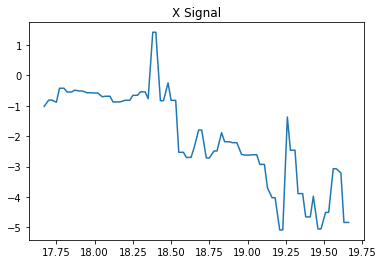

In [58]:
plt.plot(ttime_1, ts_1)
#smoothed_signal = calc_moving_avg(trunc_signal, 25, trunc_time, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80)
#plt.plot(ttime_1, ss_1)
plt.title("X Signal")
plt.show()

In [4]:
dt = 0.001
B = 6.5*10**-3   # temperature lapse rate in troposphere in K/m
R = 287   # ideal gas constant in J/(kg.K)
g = 9.80665  # gravity at sea level in m/s2
T0 = 288.15   # standard air temperature in K
P0 = 101.325   # standard air pressure in kPa
pi = math.pi
ft = 3.2884  # ft/m

In [5]:
################## DATA FRAME ##################
#datafile = '../Fullscale21.csv'
datafile = '../Data/Trunc_Fullscale1.csv'
fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

In [6]:
imu_t = df['Timestamp'].values
imu_t = imu_t - imu_t[0]
imu_N = len(imu_t)
imu_ax = df['LinearAccelNed X'].values
imu_ay = df['LinearAccelNed Y'].values
imu_az = df['LinearAccelNed Z'].values * -1
imu_pres = df['Pres']

################## INIT VECTORS  ##################
imu_vx, imu_vy, imu_vz, imu_x, imu_y, imu_z = (np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)))

################## Find velocity and position  ##################
for i in range(imu_N-1):
    imu_vz[i+1] = imu_vz[i] + imu_az[i]*(imu_t[i+1] - imu_t[i])
    imu_z[i+1] = imu_z[i] + imu_vz[i]*(imu_t[i+1] - imu_t[i])
    
    imu_vx[i+1] = imu_vx[i] + imu_ax[i]*(imu_t[i+1] - imu_t[i])
    imu_x[i+1] = imu_x[i] + imu_vx[i]*(imu_t[i+1] - imu_t[i])
    
    imu_vy[i+1] = imu_vy[i] + imu_ay[i]*(imu_t[i+1] - imu_t[i])
    imu_y[i+1] = imu_y[i] + imu_vy[i]*(imu_t[i+1] - imu_t[i])
    
################## Find alt  ##################
def nasa_pres(P, P0, T0, R, B, g):
    imu_temp = T0*(P/P0)**(R*B/g)
    imu_alt = (T0 - imu_temp)/B
    return imu_alt

vec_NASA_pres = np.vectorize(nasa_pres)
imu_alt = vec_NASA_pres(imu_pres, P0, T0, R, B, g)   # * ft + 600
imu_alt = imu_alt - imu_alt[imu_N-1]
imu_alt = [val if val > 0 else 0 for val in imu_alt]

In [7]:
imu_start_time, imu_end_time, takeoff_time, a_1 = find_peak_and_wait(np.array(imu_ax), imu_t)

trunc_signal = imu_ax[imu_start_time:imu_end_time]
trunc_time = imu_t[imu_start_time:imu_end_time]

smoothed_signal = calc_moving_avg(trunc_signal, 25, trunc_time, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80)

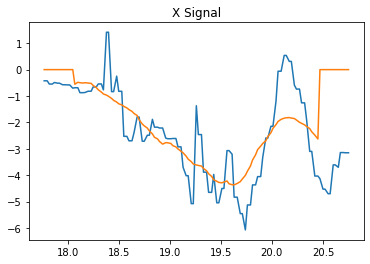

In [21]:
plt.plot(trunc_time, trunc_signal)
smoothed_signal = calc_moving_avg(trunc_signal, 25, trunc_time, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80)
plt.plot(trunc_time, smoothed_signal)
plt.title("X Signal")
plt.show()

In [13]:
if max(np.array(smoothed_signal)) > 0.1:
    max_accel = max(np.array(smoothed_signal))
    flip = 1
else:
    max_accel = max(abs(np.array(smoothed_signal)))
    flip = -1
w_0 = 0.5*max_accel*(trunc_time[-1] - trunc_time[0])
K = a_1/w_0**2 
#w_0

In [14]:
w_0

6.508457080000041

In [15]:
## DERIVED PARAMETERS
w_0_mph = w_0/0.44704
z_0 = max(imu_alt) # apogee altitude in m

################## CONSTANT WIND PROFILE & AIR DENSITY  ##################
wind_profile_x = np.zeros((imu_N))
density_profile = np.zeros((imu_N))

z0 = max(imu_alt) # apogee altitude in m

for i in range(imu_N):
    T = T0 - B * imu_alt[i]
    P = P0 * 1000 * (T/T0)**(g/(R*B))
    density_profile[i] = P/(R*T)
    if imu_alt[i] < 2:
        wind_profile_x[i] = w_0*((2/z0)**(1/7))
    else:
        wind_profile_x[i] = w_0*((imu_alt[i]/z0)**(1/7))

In [16]:
x1, t1 = model1(imu_t[imu_start_time], imu_t, imu_ax, imu_vx, imu_x, dt, a_1, imu_alt, wind_profile_x, density_profile, K)
x2, t2 = model2(imu_t, dt, imu_alt, wind_profile_x, density_profile, K)

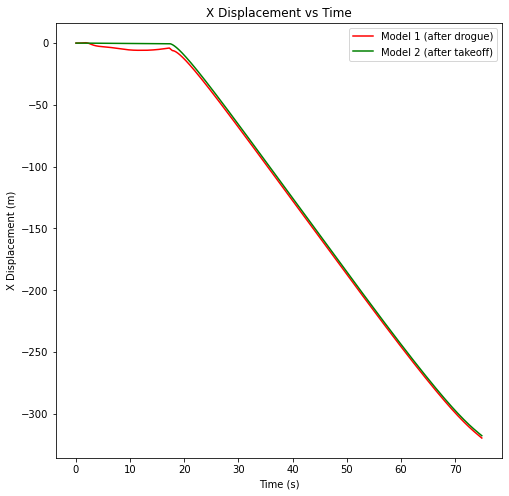

In [17]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(t1, x1*flip, color='red', label='Model 1 (after drogue)')
ax.plot(t2, x2*flip, color='green', label='Model 2 (after takeoff)')
ax.set_title("X Displacement vs Time")  # 'interpreter','latex', 'FontSize', 16
ax.set_xlabel("Time (s)")  # 'interpreter','latex', 'FontSize', 16
ax.set_ylabel("X Displacement (m)")  # 'interpreter','latex', 'FontSize', 16
ax.legend()
plt.show()

In [19]:
imu_start_time, imu_end_time, takeoff_time, a_1 = find_peak_and_wait(np.array(imu_ay), imu_t)

trunc_signal_y = imu_ay[imu_start_time:imu_end_time]
trunc_time_y = imu_t[imu_start_time:imu_end_time]

smoothed_signal_y = calc_moving_avg(trunc_signal_y, 25, trunc_time_y, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80)

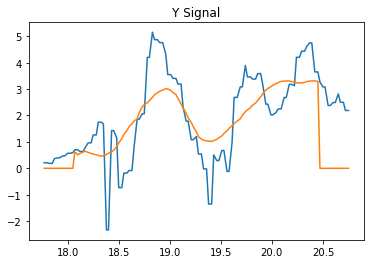

In [20]:
plt.plot(trunc_time_y, trunc_signal_y)
smoothed_signal_y = calc_moving_avg(trunc_signal_y, 25, trunc_time_y, dynamic_window=False, dynamic_n_timing=140, dynamic_n=80)
plt.plot(trunc_time_y, smoothed_signal_y)
plt.title("Y Signal")
plt.show()

In [ ]:
if max(np.array(smoothed_signal_y)) > 0.1:
    max_accel = max(np.array(smoothed_signal_y))
    flip = 1
else:
    max_accel = max(abs(np.array(smoothed_signal_y)))
    flip = -1
w_0_y = 0.5*max_accel*(trunc_time_y[-1] - trunc_time_y[0])
K = a_1/w_0_y**2

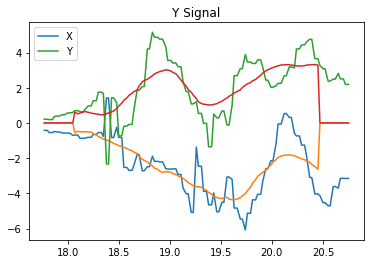

In [23]:
plt.plot(trunc_time, trunc_signal, label="X")
plt.plot(trunc_time, smoothed_signal)
plt.plot(trunc_time_y, trunc_signal_y, label="Y")
plt.plot(trunc_time_y, smoothed_signal_y)
plt.title("Y Signal")
plt.legend()
plt.show()

In [18]:
################## CONSTANT WIND PROFILE & AIR DENSITY  ##################
## DERIVED PARAMETERS
w_0_y_mph = w_0_y/0.44704
wind_profile_y = np.zeros((imu_N))
density_profile = np.zeros((imu_N))
z0 = max(imu_alt) # apogee altitude in m

for i in range(imu_N):
    T = T0 - B * imu_alt[i]
    P = P0 * 1000 * (T/T0)**(g/(R*B))
    density_profile[i] = P/(R*T)
    if imu_alt[i] < 2:
        wind_profile_y[i] = w_0_y*((2/z0)**(1/7))
    else:
        wind_profile_y[i] = w_0_y*((imu_alt[i]/z0)**(1/7))

In [19]:
y1, ty1 = model1(imu_t[imu_start_time], imu_t, imu_ay, imu_vy, imu_y, dt, a_1, imu_alt, wind_profile_y, density_profile, K)
y2, ty2 = model2(imu_t, dt, imu_alt, wind_profile_y, density_profile, K)

C:\Users\kdmen\Desktop\VADL\code\IMU_VV\03_Path_Recon\model_funcs.py:107: RuntimeWarning: overflow encountered in double_scalars
  sim_ax[i+1] = K * ((wind_profile_x[imu_index] - sim_vx[i+1])**2)
C:\Users\kdmen\Desktop\VADL\code\IMU_VV\03_Path_Recon\model_funcs.py:299: RuntimeWarning: overflow encountered in double_scalars
  ax[i+1] = K * ((wind_profile_x[imu_index1] - vx[i+1])**2)


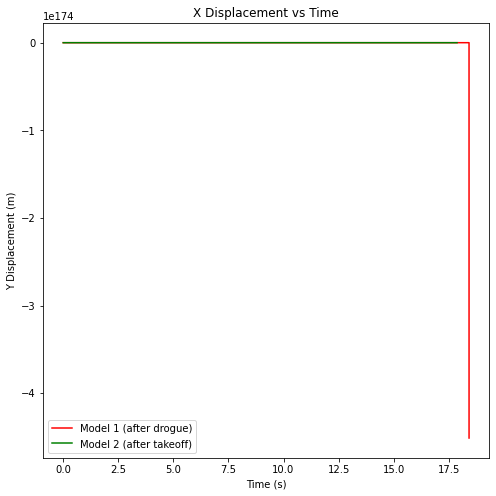

In [33]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(ty1, y1*flip, color='red', label='Model 1 (after drogue)')
ax.plot(ty2, y2*flip, color='green', label='Model 2 (after takeoff)')
ax.set_title("Y Displacement vs Time")  # 'interpreter','latex', 'FontSize', 16
ax.set_xlabel("Time (s)")  # 'interpreter','latex', 'FontSize', 16
ax.set_ylabel("Y Displacement (m)")  # 'interpreter','latex', 'FontSize', 16
ax.legend()
plt.show()